In [3]:
%load_ext autoreload
%autoreload 2
from fireants.io import Image, BatchedImages
from fireants.registration.moments import MomentsRegistration
from fireants.registration.rigid import RigidRegistration
from fireants.registration.greedy import GreedyRegistration
from fireants.registration.affine import AffineRegistration
import matplotlib.pyplot as plt
import SimpleITK as sitk
from time import time

USE_FFO: True
FFO_AVAILABLE: True
Using FFO: True


In [5]:
GreedyRegistration?

Init signature:
GreedyRegistration(
    scales: List[int],
    iterations: List[float],
    fixed_images: fireants.io.image.BatchedImages,
    moving_images: fireants.io.image.BatchedImages,
    loss_type: str = 'cc',
    deformation_type: str = 'compositive',
    optimizer: str = 'Adam',
    optimizer_params: dict = {},
    optimizer_lr: float = 0.5,
    integrator_n: Union[str, int] = 7,
    mi_kernel_type: str = 'gaussian',
    cc_kernel_type: str = 'rectangular',
    cc_kernel_size: int = 7,
    smooth_warp_sigma: float = 0.5,
    smooth_grad_sigma: float = 1.0,
    loss_params: dict = {},
    reduction: str = 'mean',
    tolerance: float = 1e-06,
    max_tolerance_iters: int = 10,
    init_affine: Optional[torch.Tensor] = None,
    warp_reg: Union[Callable, torch.nn.modules.module.Module, NoneType] = None,
    displacement_reg: Union[Callable, torch.nn.modules.module.Module, NoneType] = None,
    blur: bool = True,
    freeform: bool = False,
    custom_loss: torch.nn.modules.modu

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
def triplanar(x):
    vmin = x.min()
    vmax = x.max() * 0.8

    c1, c2, c3 = [d//2 + 3 for d in x.shape]

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(x[c1], cmap='gray', vmin=vmin, vmax=vmax)
    axs[1].imshow(x[:, c2], cmap='gray', vmin=vmin, vmax=vmax)
    axs[2].imshow(x[..., c3], cmap='gray', vmin=vmin, vmax=vmax)

    for ax in axs.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def triplanar_hist(x):
    vmin = x.min()
    vmax = x.max() * 0.8

    c1, c2, c3 = [d//2 + 3 for d in x.shape]

    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    axs[0].imshow(x[c1], cmap='gray', vmin=vmin, vmax=vmax)
    axs[1].imshow(x[:, c2], cmap='gray', vmin=vmin, vmax=vmax)
    axs[2].imshow(x[..., c3], cmap='gray', vmin=vmin, vmax=vmax)
    axs[3].hist(x.flatten(), bins=256)

    for ax in axs.flat[:3]:
        ax.axis('off')

    axs[3].set_yscale('log')
    plt.tight_layout()
    plt.show()

def to_np(x):
    if type(x) == np.ndarray:
        return x
    return x.detach().cpu().numpy().squeeze()

# Load data

In [4]:
with open("/home/sremedi1/projects/ost1_template/fpaths.txt", 'r') as f:
    fpath_list = [l.strip() for l in f.readlines()]

In [5]:
fpath_list

['/data/t1w_dataset/train/a4/a4_sub-00584_ses-03_t1w_run-01.nii',
 '/data/t1w_dataset/train/a4/a4_sub-01786_ses-04_t1w_run-01.nii',
 '/data/t1w_dataset/train/a4/a4_sub-01197_ses-04_t1w_run-01.nii',
 '/data/t1w_dataset/train/a4/a4_sub-01787_ses-03_t1w_run-01.nii',
 '/data/t1w_dataset/train/a4/a4_sub-00577_ses-07_t1w_run-01.nii',
 '/data/t1w_dataset/train/a4/a4_sub-01189_ses-05_t1w_run-01.nii',
 '/data/t1w_dataset/train/a4/a4_sub-01774_ses-02_t1w_run-01.nii',
 '/data/t1w_dataset/train/a4/a4_sub-00535_ses-04_t1w_run-01.nii',
 '/data/t1w_dataset/train/a4/a4_sub-01761_ses-04_t1w_run-01.nii']

In [6]:
# load the images
fixed = BatchedImages([Image.load_file("/data/t1w_dataset/train/a4/a4_sub-01566_ses-01_t1w_run-01.nii")])
movings = BatchedImages([Image.load_file(f) for f in fpath_list])

# Repeat the batch element to allow registration in parallel
fixed.broadcast(movings.shape[0])

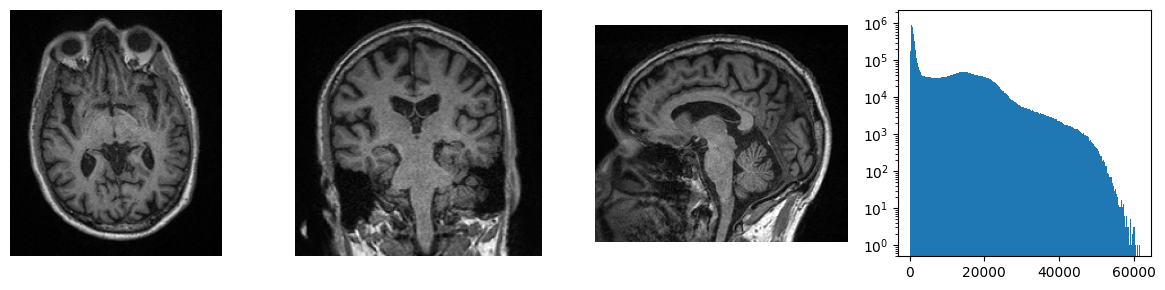

In [7]:
triplanar_hist(to_np(fixed.images[0].array)[::-1])

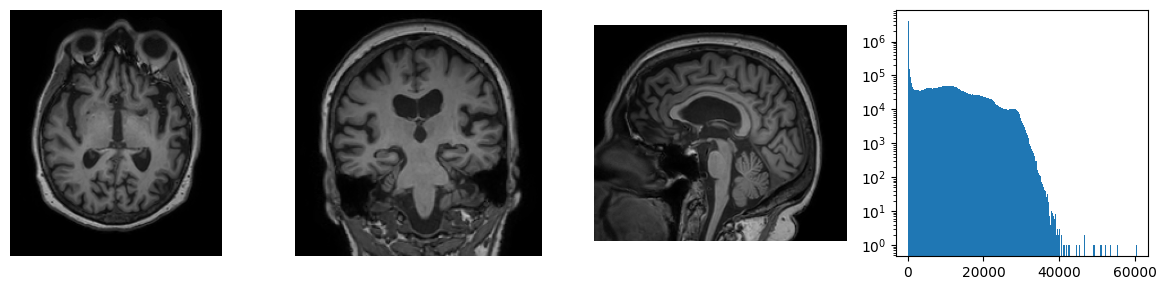

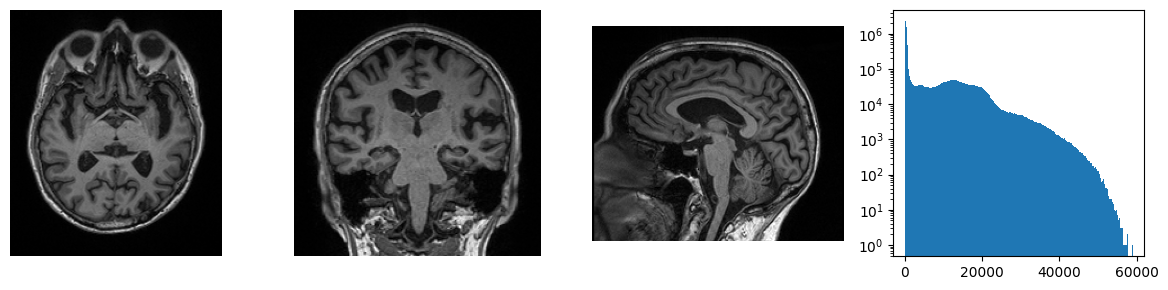

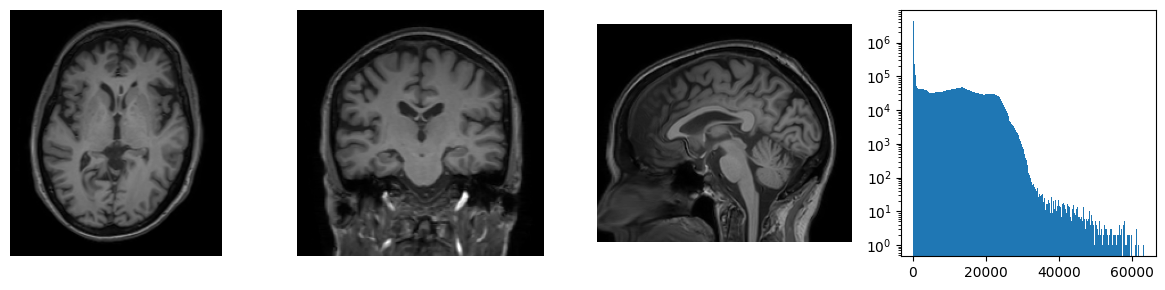

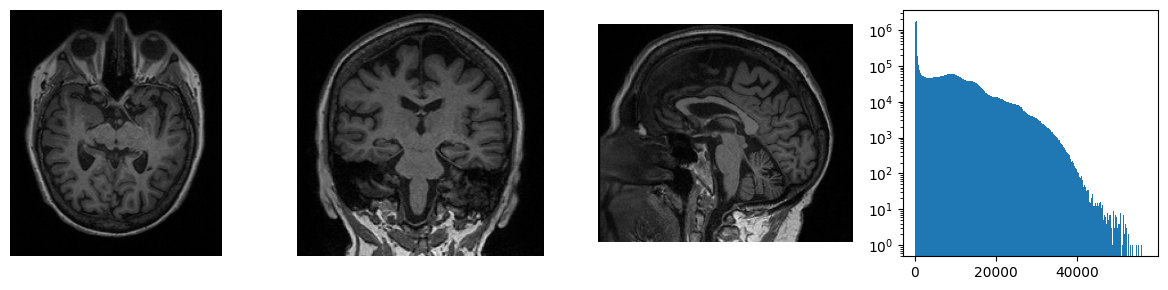

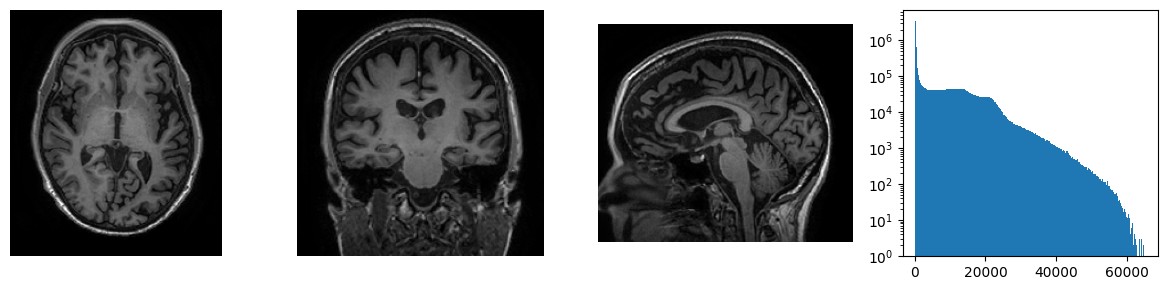

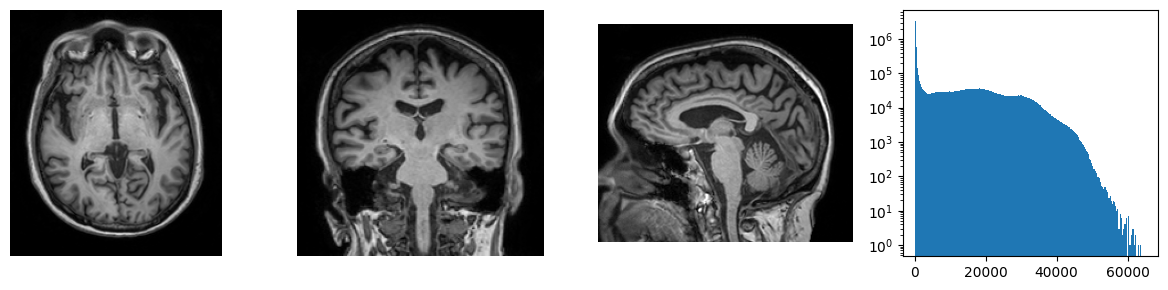

In [8]:
for moved_img in movings.images:
    triplanar_hist(to_np(moved_img.array)[::-1])

# Moment

In [9]:
moments = MomentsRegistration(
    scale=4, 
    moments=1,
    fixed_images=fixed,
    moving_images=movings, 
)
moments.optimize()
moved = moments.evaluate(fixed_images=fixed, moving_images=movings)
init_moment_rigid = moments.get_rigid_moment_init()
init_moment_transl = moments.get_rigid_transl_init()

INFO:fireants.registration.abstract:Registration of type MomentsRegistration initialized with dtype torch.float32


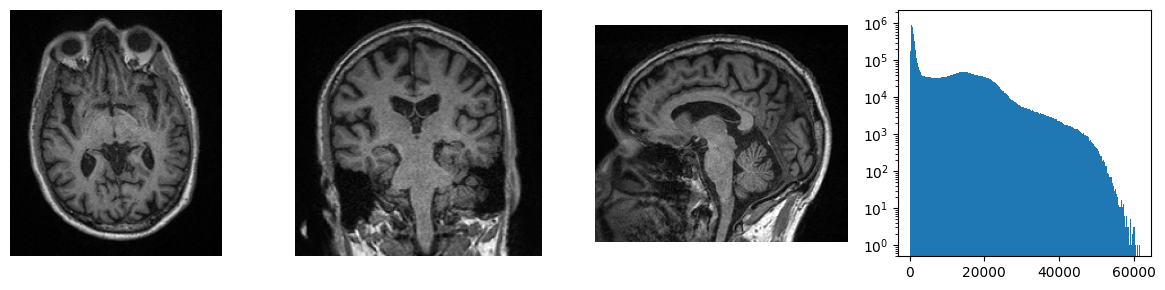

In [10]:
triplanar_hist(to_np(fixed.images[0].array)[::-1])

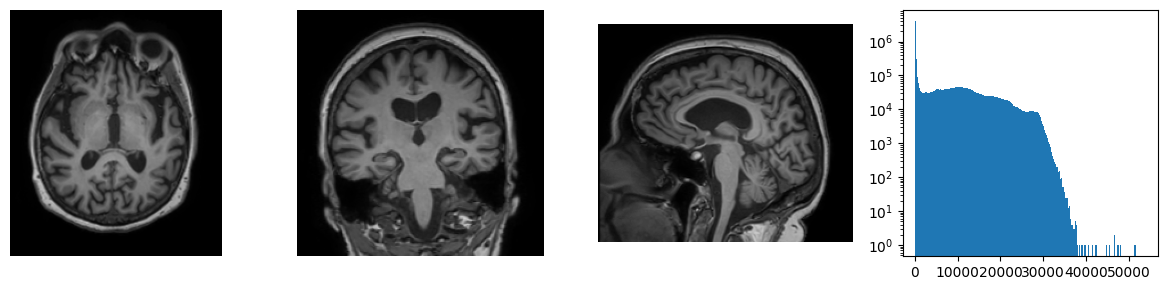

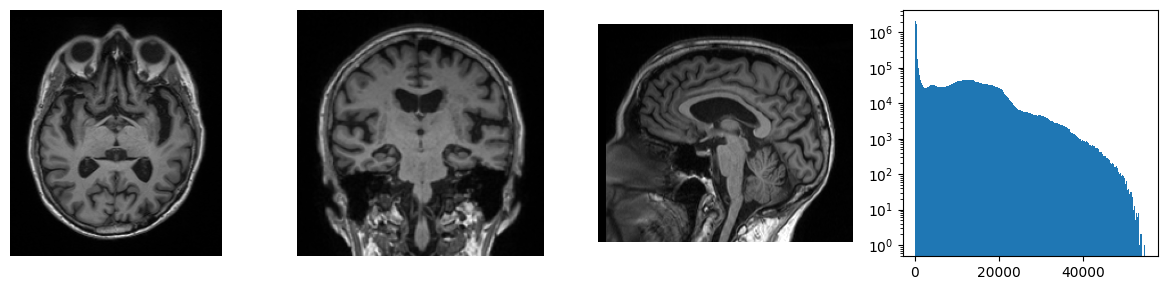

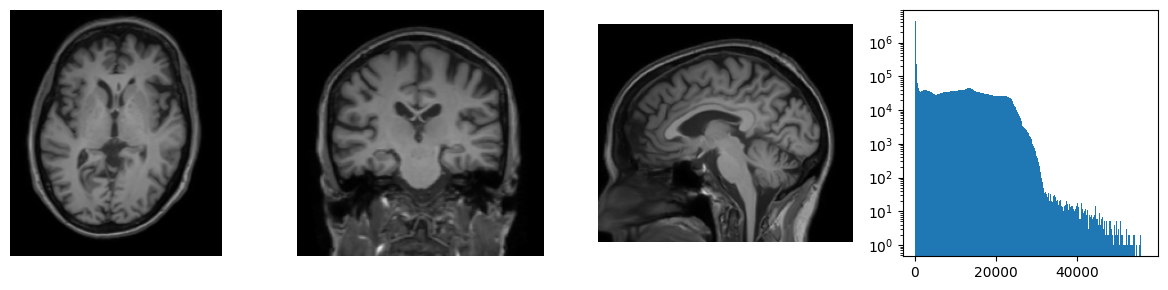

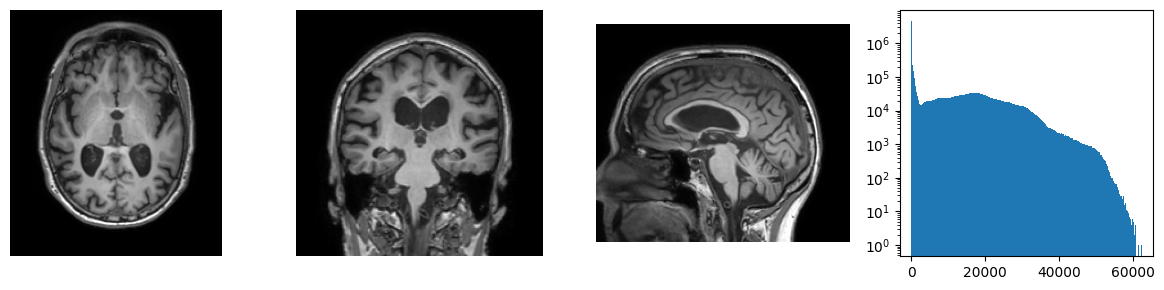

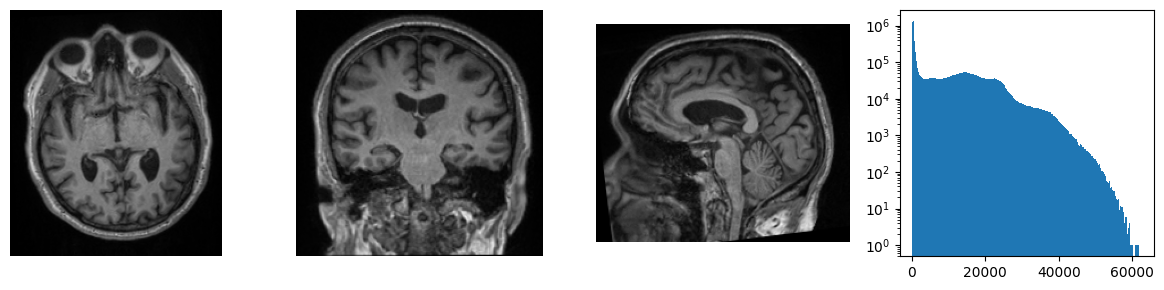

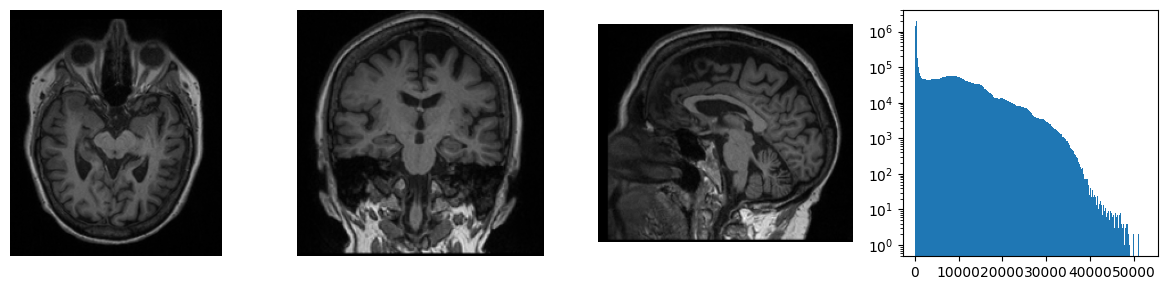

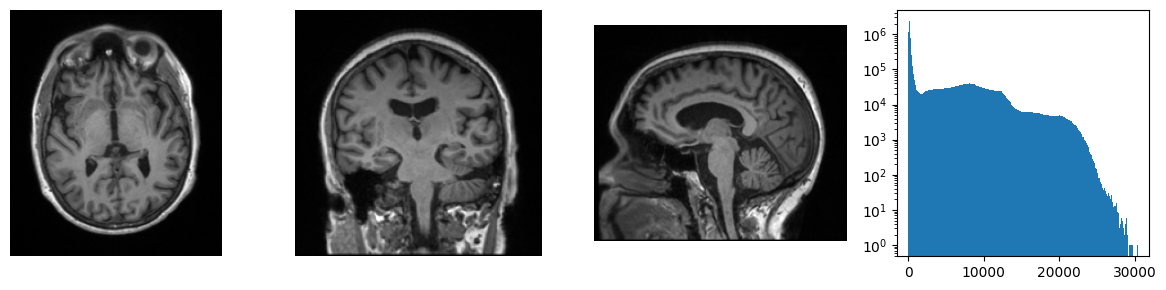

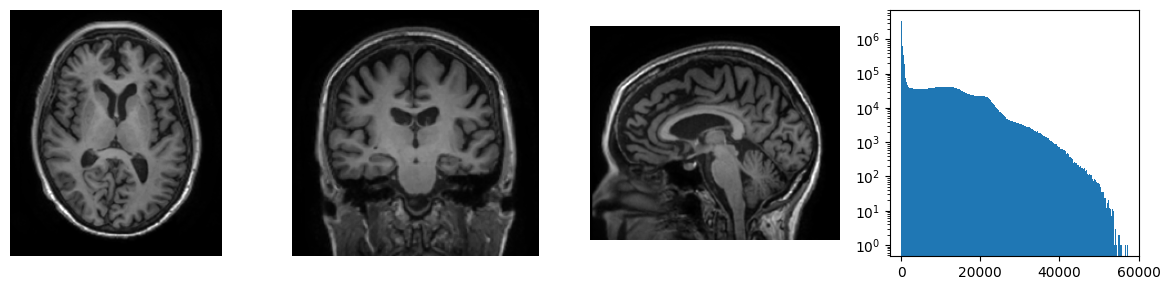

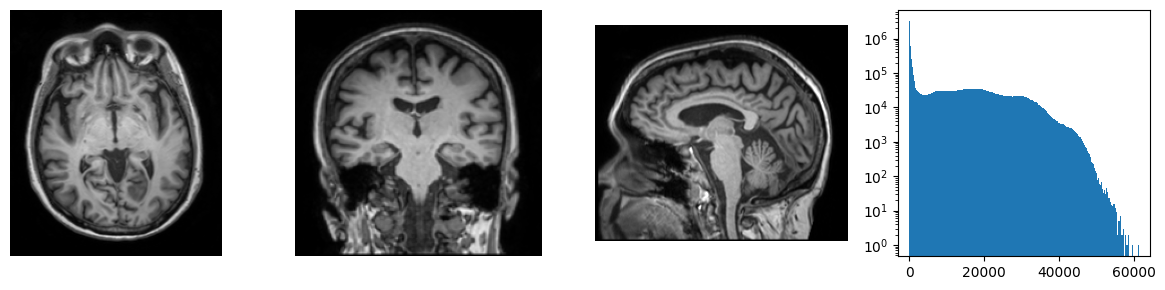

In [11]:
for moved_img in moved:
    triplanar_hist(to_np(moved_img)[::-1])

# Rigid

In [12]:
# Rigid
scales = [4, 2, 1]
iterations = [200, 100, 50]
optim = 'Adam'
lr = 3e-3

# create affine registration object
rigid = RigidRegistration(
    scales, 
    iterations,
    fixed_images=fixed,
    moving_images=movings, 
    optimizer=optim, 
    optimizer_lr=lr, 
    cc_kernel_size=5,
    init_translation=init_moment_transl,
    init_moment=init_moment_rigid,
)

# run registration
rigid.optimize()
init_rigid = rigid.get_rigid_matrix()

moved = rigid.evaluate(fixed_images=fixed, moving_images=movings)

INFO:fireants.registration.abstract:Registration of type RigidRegistration initialized with dtype torch.float32
scale: 1, iter: 49/50, loss: -0.116164: 100%|██████████████████████████████████████| 50/50 [00:08<00:00,  5.77it/s]


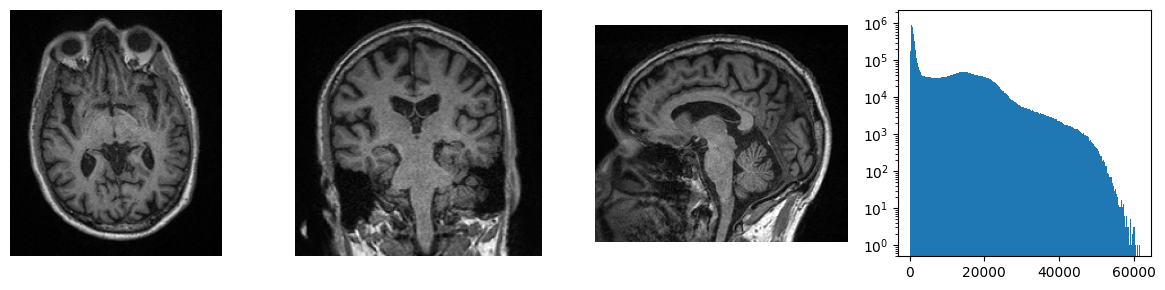

In [13]:
triplanar_hist(to_np(fixed.images[0].array)[::-1])

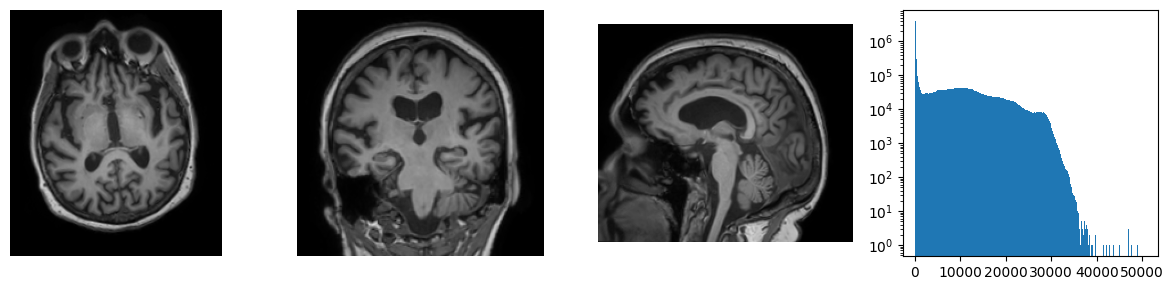

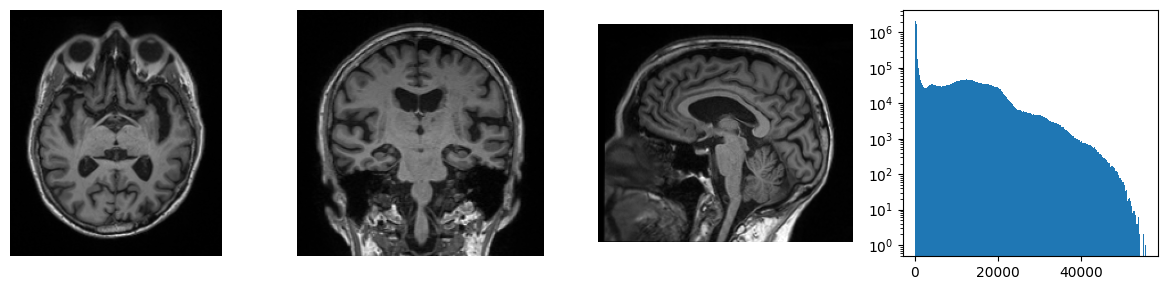

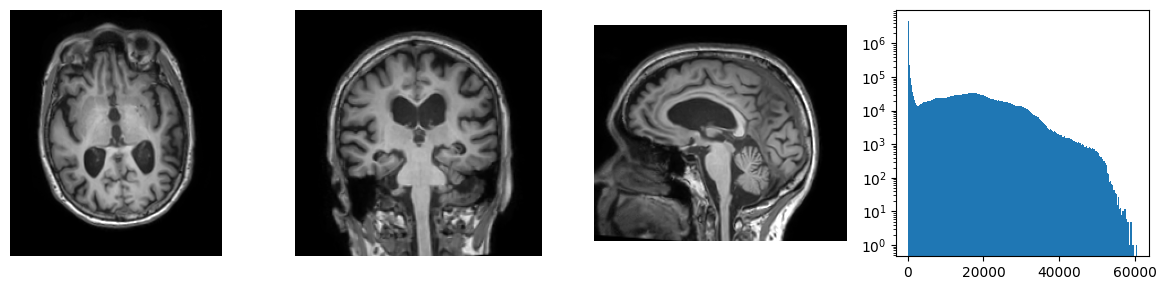

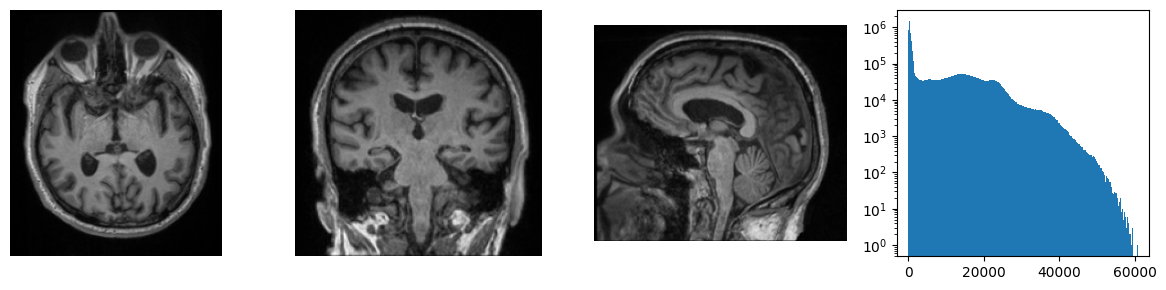

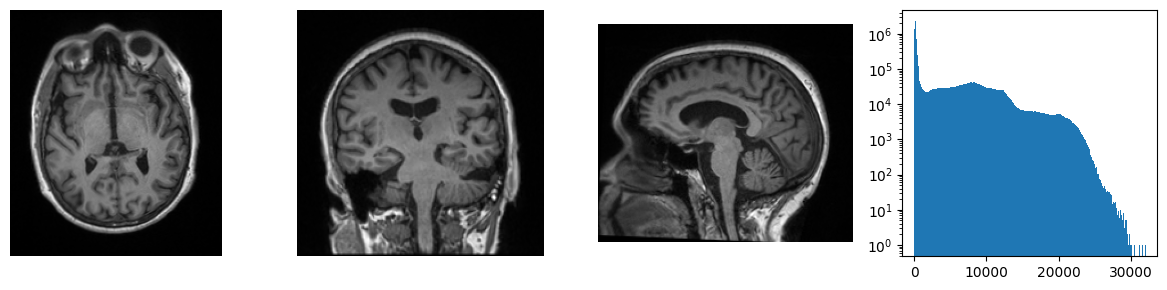

In [14]:
for moved_img in moved:
    triplanar_hist(to_np(moved_img)[::-1])

# Affine

In [15]:
# Affine
scales = [4, 2, 1]
iterations = [200, 100, 50]
optim = 'Adam'
lr = 3e-3

# create affine registration object
affine = AffineRegistration(
    scales, 
    iterations,
    fixed_images=fixed,
    moving_images=movings, 
    optimizer=optim, 
    optimizer_lr=lr, 
    cc_kernel_size=5,
    init_rigid=init_rigid,
)

# run registration
affine.optimize()
init_affine = affine.get_affine_matrix().detach()

moved = affine.evaluate(fixed_images=fixed, moving_images=movings)

INFO:fireants.registration.abstract:Registration of type AffineRegistration initialized with dtype torch.float32
scale: 1, iter: 49/50, loss: -0.139008: 100%|██████████████████████████████████████| 50/50 [00:08<00:00,  5.72it/s]


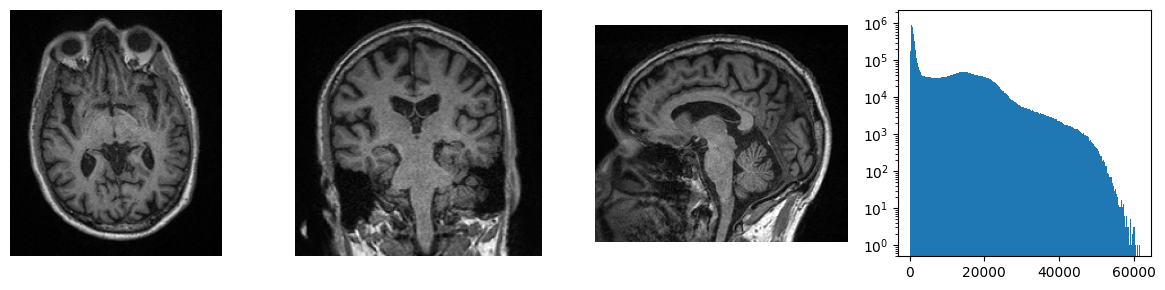

In [16]:
triplanar_hist(to_np(fixed.images[0].array)[::-1])

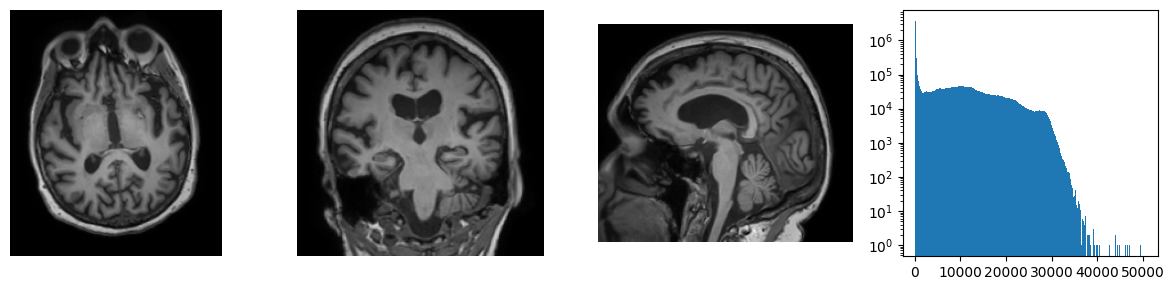

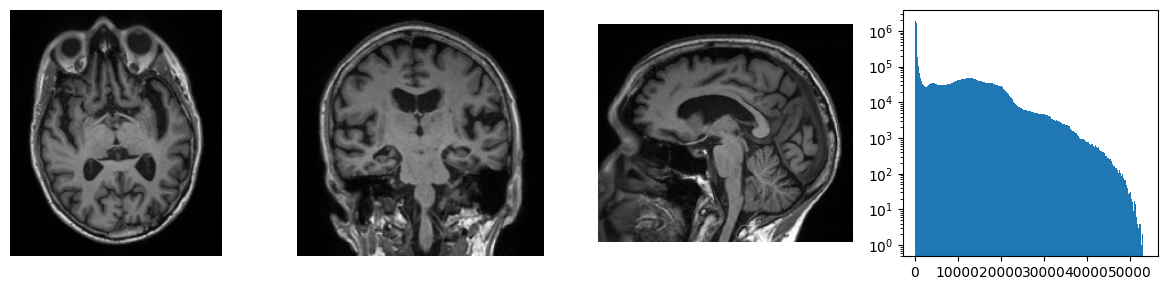

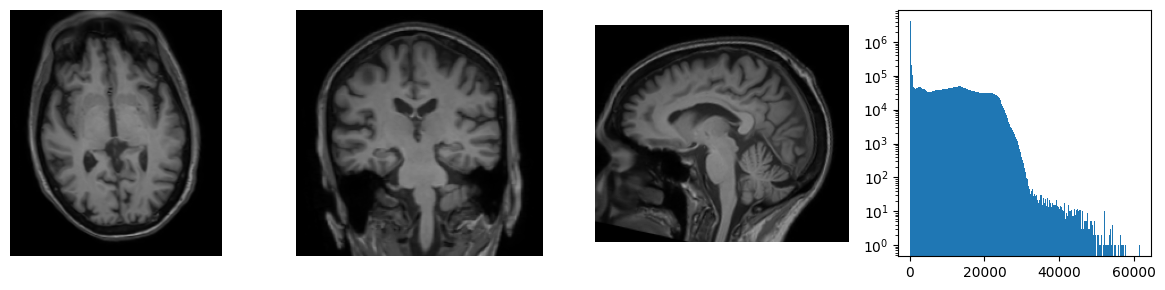

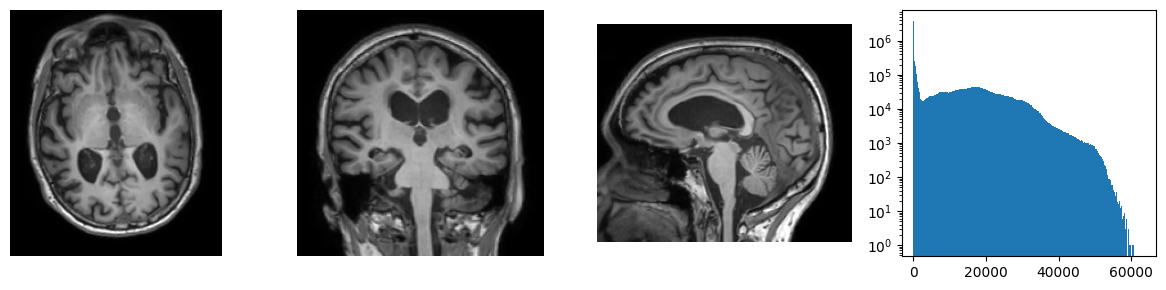

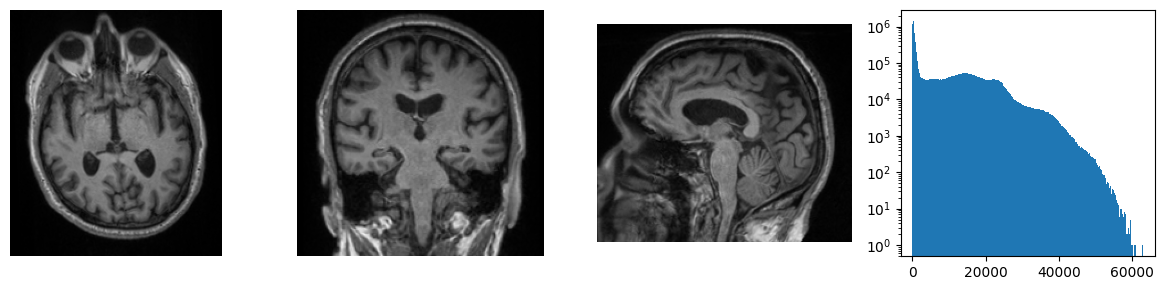

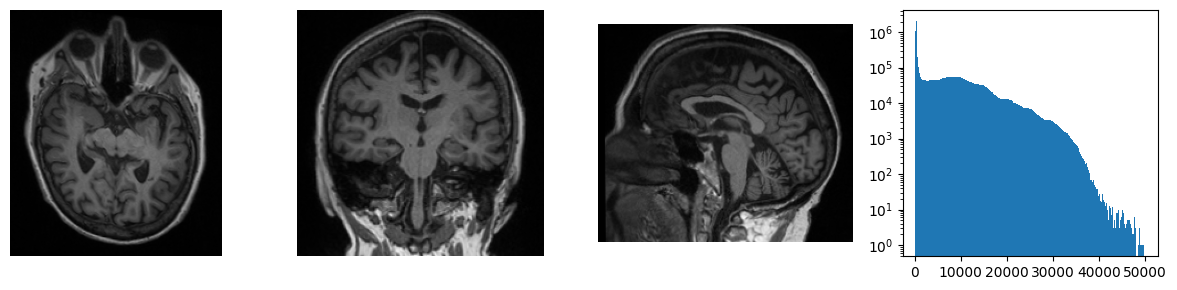

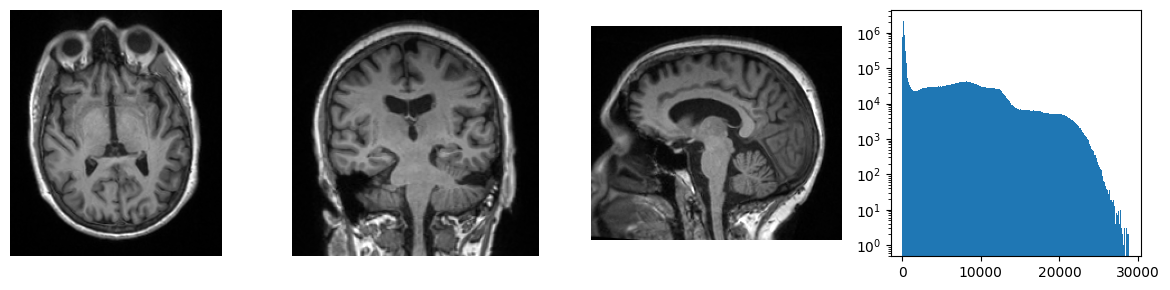

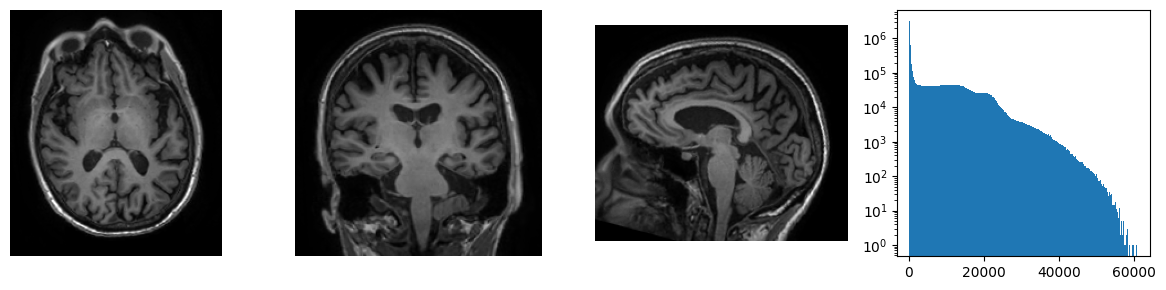

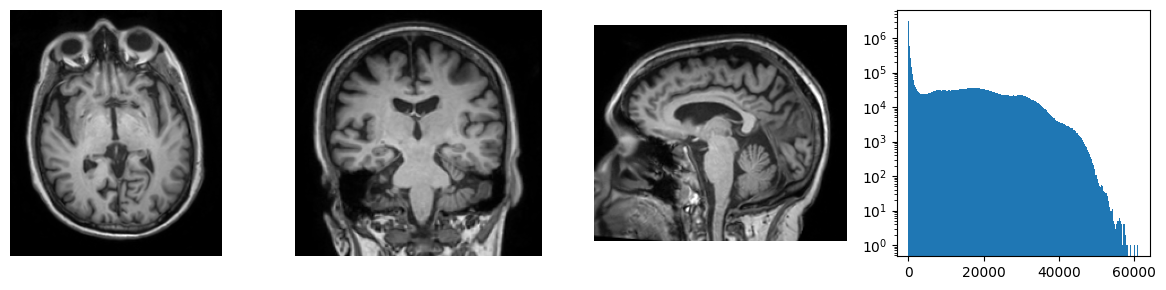

In [17]:
for moved_img in moved:
    triplanar_hist(to_np(moved_img)[::-1])

# Deformable

INFO:fireants.registration.abstract:Registration of type GreedyRegistration initialized with dtype torch.float32
scale: 1, iter: 24/25, loss: -0.240841: 100%|██████████████████████████████████████| 25/25 [00:06<00:00,  3.85it/s]


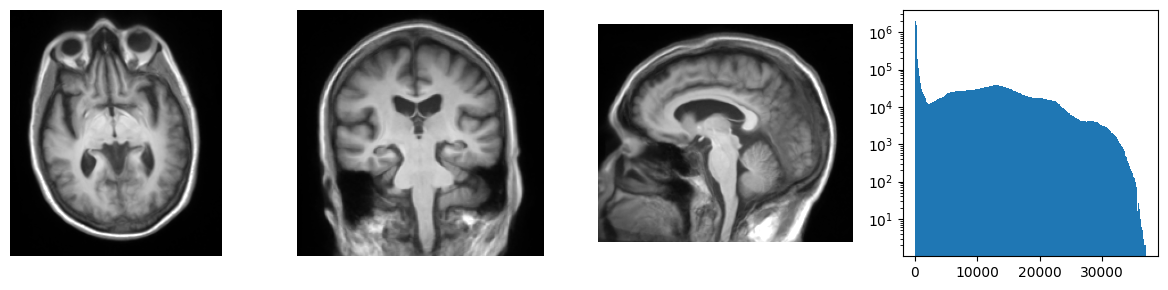

INFO:fireants.registration.abstract:Registration of type GreedyRegistration initialized with dtype torch.float32
scale: 1, iter: 24/25, loss: -0.240841: 100%|██████████████████████████████████████| 25/25 [00:06<00:00,  3.81it/s]


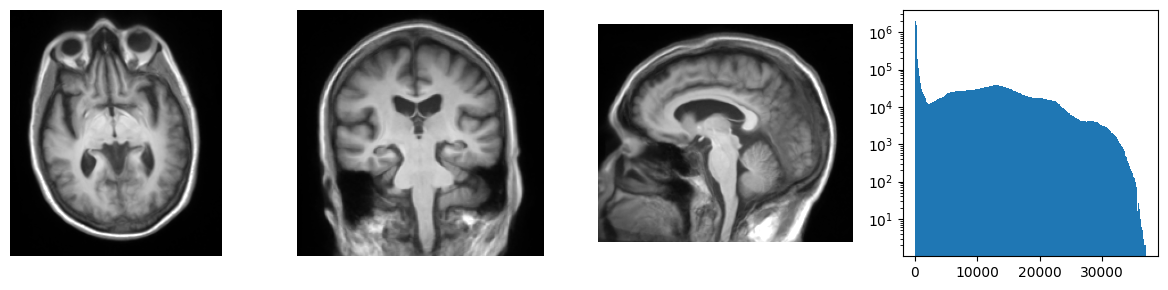

INFO:fireants.registration.abstract:Registration of type GreedyRegistration initialized with dtype torch.float32
scale: 1, iter: 16/25, loss: -0.239011:  64%|████████████████████████▎             | 16/25 [00:04<00:02,  3.52it/s]


KeyboardInterrupt: 

In [21]:
# Given 1st Moment -> Rigid -> Affine, iteratively construct an atlas 
# relying on GreedyRegistration
atlas_arr = torch.zeros_like(fixed.images[0].array, device=fixed.images[0].array.device)


for _ in range(5):
    # ===== Register =====
    reg = GreedyRegistration(
        scales=[4, 2, 1], 
        iterations=[200, 100, 25], 
        fixed_images=fixed, 
        moving_images=movings,
        cc_kernel_size=5, 
        deformation_type='compositive', 
        smooth_grad_sigma=0.5, 
        optimizer='adam',
        optimizer_lr=0.5, 
        init_affine=init_affine,
    )
    reg.optimize()

    # ===== Apply transform and update atlas =====
    moved = reg.evaluate(fixed_images=fixed, moving_images=movings)
    atlas_arr = moved.mean(dim=0).unsqueeze(0)

    # ===== Start the next loop with a new target =====
    fixed.array = atlas_arr.detach()

    # ===== Display progress =====
    triplanar_hist(to_np(atlas_arr)[::-1])

In [ ]:
triplanar_hist(to_np(fixed.images[0].array)[::-1])

In [ ]:
triplanar_hist(to_np(atlas_arr)[::-1])

In [6]:
from fireants.utils.imageutils import LaplacianFilter

In [8]:
laplace = LaplacianFilter(dims=3, device='cpu', learning_rate=0.5)

In [34]:
laplace.laplacian /= laplace.laplacian.sum()

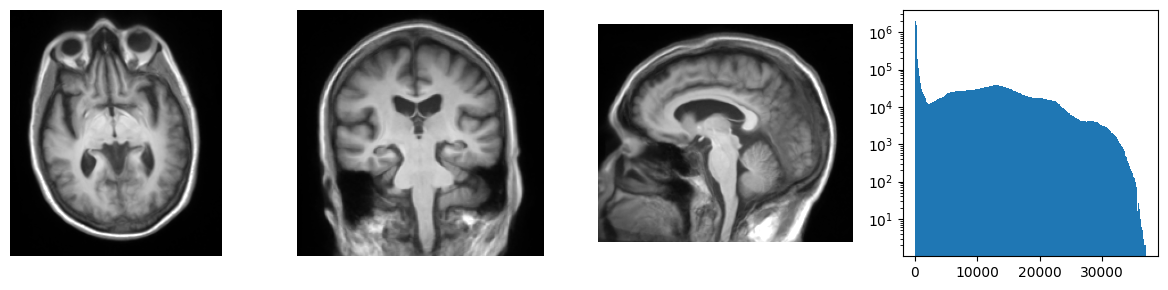

In [37]:
triplanar_hist(to_np(atlas_arr)[::-1])

In [38]:
tmp = laplace(atlas_arr)

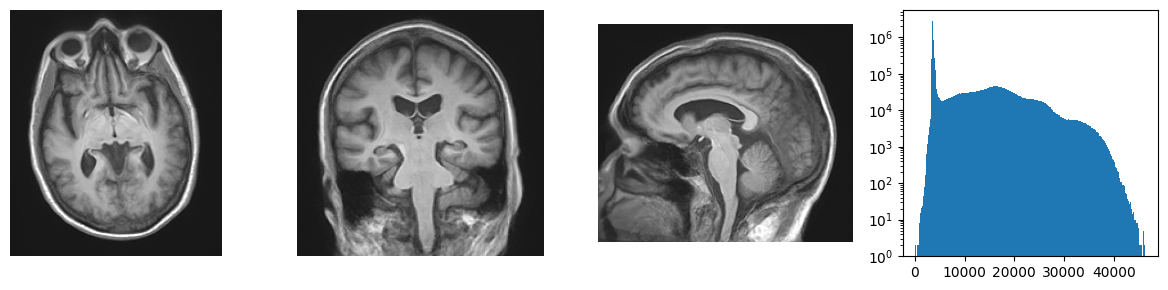

In [39]:
triplanar_hist(to_np(tmp)[::-1])